<a href="https://colab.research.google.com/github/Sujoy-004/diabetes-risk-ml/blob/main/diabetes_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### impport and install data

In [1]:
# Cell 1: Import and Install Libraries
!pip install xgboost shap scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


### Load and inspect data

In [16]:
try:
    df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv')
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("-" * 40)
except Exception as e:
    print(f"Error loading dataset: {e}")

# Display first few rows
print("First 5 rows:")
print(df.head().to_string())
print()

# Dataset info
print("Dataset Information:")
df.info()
print()

# Statistical summary
print("Statistical Summary:")
print(df.describe().to_string())
print()

# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print()

# Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check target distribution
print("\nTarget variable distribution:")
print(df['Outcome'].value_counts())
print(df['Outcome'].value_counts(normalize=True))

Dataset loaded successfully!
Shape: (768, 9)
----------------------------------------
First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1                     0.167   21        0
4            0      137             40             35      168  43.1                     2.288   33        1

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregn

### code and impute data

In [3]:
# Create a copy to preserve original data
df_clean = df.copy()

# Replace 0s with NaN in physiologically impossible columns
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print(f"Replacing 0s with NaN in columns: {cols_with_zero}")

# Show zeros before replacement
print("\nZeros in each column before replacement:")
for col in cols_with_zero:
    zero_count = (df_clean[col] == 0).sum()
    print(f"{col}: {zero_count} zeros ({zero_count/len(df_clean)*100:.1f}%)")

df_clean[cols_with_zero] = df_clean[cols_with_zero].replace(0, np.nan)

# Show NaN count after replacement
print("\nMissing values after replacing 0s with NaN:")
missing_counts = df_clean.isnull().sum()
print(missing_counts[missing_counts > 0])
print(f"\nTotal missing values: {df_clean.isnull().sum().sum()}")

# Impute missing values using KNN Imputer
print("\nImputing missing values using KNN (k=5)...")
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)

# Verify no missing values after imputation
print(f"Missing values after imputation: {df_imputed.isnull().sum().sum()}")

# Show comparison of original vs imputed data
print("\nComparison - Original vs Imputed (first 5 rows):")
print("Original data (with NaN):")
print(df_clean[cols_with_zero].head())
print("\nImputed data:")
print(df_imputed[cols_with_zero].head())

Replacing 0s with NaN in columns: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

Zeros in each column before replacement:
Glucose: 5 zeros (0.7%)
BloodPressure: 35 zeros (4.6%)
SkinThickness: 227 zeros (29.6%)
Insulin: 374 zeros (48.7%)
BMI: 11 zeros (1.4%)

Missing values after replacing 0s with NaN:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Total missing values: 652

Imputing missing values using KNN (k=5)...
Missing values after imputation: 0

Comparison - Original vs Imputed (first 5 rows):
Original data (with NaN):
   Glucose  BloodPressure  SkinThickness  Insulin   BMI
0    148.0           72.0           35.0      NaN  33.6
1     85.0           66.0           29.0      NaN  26.6
2    183.0           64.0            NaN      NaN  23.3
3     89.0           66.0           23.0     94.0  28.1
4    137.0           40.0           35.0    168.0  43.1

Imputed data:
   Glucose  BloodPressure  S

### scale featuring

In [6]:
# Separate features and target
X_original = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome'].astype(int)  # Ensure target is integer

print(f"Features: {list(X_original.columns)}")
print(f"Target variable: Outcome")
print(f"Original feature shape: {X_original.shape}")
print(f"Target shape: {y.shape}")

# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)
X = pd.DataFrame(X_scaled, columns=X_original.columns)

print(f"Scaled feature shape: {X.shape}")

# Show scaling results
print("\nOriginal features (first 3 rows):")
print(X_original.head(3).to_string())
print("\nScaled features (first 3 rows):")
print(X.head(3).to_string())

# Verify scaling worked correctly
print(f"\nScaled features mean (should be ~0):")
print(X.mean().round(10))
print(f"\nScaled features std (should be ~1):")
print(X.std().round(3))

print(f"\nTarget distribution:")
print(y.value_counts().sort_index())

Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Target variable: Outcome
Original feature shape: (768, 8)
Target shape: (768,)
Scaled feature shape: (768, 8)

Original features (first 3 rows):
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction   Age
0          6.0    148.0           72.0           35.0    169.0  33.6                     0.627  50.0
1          1.0     85.0           66.0           29.0     58.6  26.6                     0.351  31.0
2          8.0    183.0           64.0           25.8    164.6  23.3                     0.672  32.0

Scaled features (first 3 rows):
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  DiabetesPedigreeFunction       Age
0     0.639947  0.866296      -0.030443       0.624914  0.160899  0.170392                  0.468492  1.425995
1    -0.844885 -1.200858      -0.522308      -0.012166 -0.961951 -0.8467

### split

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train-Test Split completed!")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature dimensions: {X_train.shape[1]}")

# Verify stratification worked
print("\nTarget distribution verification:")
print("Training set distribution:")
train_dist = y_train.value_counts(normalize=True).sort_index()
print(train_dist)

print("\nTest set distribution:")
test_dist = y_test.value_counts(normalize=True).sort_index()
print(test_dist)

print("\nOriginal dataset distribution:")
orig_dist = y.value_counts(normalize=True).sort_index()
print(orig_dist)

print(f"\nSplit ratio: {len(X_train)/(len(X_train)+len(X_test))*100:.1f}% train, {len(X_test)/(len(X_train)+len(X_test))*100:.1f}% test")

Train-Test Split completed!
Training set size: 614 samples
Test set size: 154 samples
Feature dimensions: 8

Target distribution verification:
Training set distribution:
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64

Test set distribution:
Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64

Original dataset distribution:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

Split ratio: 79.9% train, 20.1% test


### Model evaluation

In [8]:
print("="*50)
print("XGBOOST MODEL")
print("="*50)

# Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
print("XGBoost model training complete.")

# Evaluate XGBoost model
print("\nEvaluating XGBoost model...")
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-score: {f1_xgb:.4f}")
print(f"AUC: {roc_auc_xgb:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Feature importance
print("\nTop 5 Feature Importances:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance.head())

XGBOOST MODEL
Training XGBoost model...
XGBoost model training complete.

Evaluating XGBoost model...
Accuracy: 0.7273
Precision: 0.6304
Recall: 0.5370
F1-score: 0.5800
AUC: 0.7969

Confusion Matrix:
[[83 17]
 [25 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       100
           1       0.63      0.54      0.58        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154


Top 5 Feature Importances:
       feature  importance
1      Glucose    0.277657
5          BMI    0.132744
4      Insulin    0.124795
7          Age    0.103493
0  Pregnancies    0.100212


In [9]:
print("="*50)
print("LOGISTIC REGRESSION MODEL")
print("="*50)

# Train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
print("Logistic Regression model training complete.")

# Evaluate Logistic Regression model
print("\nEvaluating Logistic Regression model...")
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")
print(f"AUC: {roc_auc_lr:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

LOGISTIC REGRESSION MODEL
Training Logistic Regression model...
Logistic Regression model training complete.

Evaluating Logistic Regression model...
Accuracy: 0.6948
Precision: 0.5745
Recall: 0.5000
F1-score: 0.5347
AUC: 0.8146

Confusion Matrix:
[[80 20]
 [27 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       100
           1       0.57      0.50      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154



In [10]:
print("="*50)
print("RANDOM FOREST MODEL")
print("="*50)

# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
print("Random Forest model training complete.")

# Evaluate Random Forest model
print("\nEvaluating Random Forest model...")
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")
print(f"AUC: {roc_auc_rf:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importance
print("\nTop 5 Feature Importances:")
rf_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(rf_feature_importance.head())

RANDOM FOREST MODEL
Training Random Forest model...
Random Forest model training complete.

Evaluating Random Forest model...
Accuracy: 0.7078
Precision: 0.5957
Recall: 0.5185
F1-score: 0.5545
AUC: 0.8071

Confusion Matrix:
[[81 19]
 [26 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       100
           1       0.60      0.52      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154


Top 5 Feature Importances:
                    feature  importance
1                   Glucose    0.245972
4                   Insulin    0.159945
5                       BMI    0.140470
6  DiabetesPedigreeFunction    0.106967
3             SkinThickness    0.101764


In [11]:
print("="*50)
print("SVM MODEL")
print("="*50)

# Train SVM model
print("Training SVM model...")
svm_model = SVC(probability=True, random_state=42, kernel='rbf')
svm_model.fit(X_train, y_train)
print("SVM model training complete.")

# Evaluate SVM model
print("\nEvaluating SVM model...")
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print(f"AUC: {roc_auc_svm:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(cm_svm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

SVM MODEL
Training SVM model...
SVM model training complete.

Evaluating SVM model...
Accuracy: 0.7338
Precision: 0.6444
Recall: 0.5370
F1-score: 0.5859
AUC: 0.7976

Confusion Matrix:
[[84 16]
 [25 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       100
           1       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154



### Model comparision and visualization

In [12]:
print("="*50)
print("MODEL COMPARISON")
print("="*50)

# Create a dictionary to store metrics for each model
metrics_data = {
    'XGBoost': {
        'Accuracy': accuracy_xgb,
        'Precision': precision_xgb,
        'Recall': recall_xgb,
        'F1-score': f1_xgb,
        'AUC': roc_auc_xgb
    },
    'Logistic Regression': {
        'Accuracy': accuracy_lr,
        'Precision': precision_lr,
        'Recall': recall_lr,
        'F1-score': f1_lr,
        'AUC': roc_auc_lr
    },
    'Random Forest': {
        'Accuracy': accuracy_rf,
        'Precision': precision_rf,
        'Recall': recall_rf,
        'F1-score': f1_rf,
        'AUC': roc_auc_rf
    },
    'SVM': {
        'Accuracy': accuracy_svm,
        'Precision': precision_svm,
        'Recall': recall_svm,
        'F1-score': f1_svm,
        'AUC': roc_auc_svm
    }
}

# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data).T

# Print the comparison DataFrame
print("Model Performance Comparison:")
print(metrics_df.round(4))

# Find the best model for each metric
print("\nBest model for each metric:")
for metric in metrics_df.columns:
    best_model = metrics_df[metric].idxmax()
    best_score = metrics_df[metric].max()
    print(f"{metric}: {best_model} ({best_score:.4f})")

MODEL COMPARISON
Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-score     AUC
XGBoost                0.7273     0.6304  0.5370    0.5800  0.7969
Logistic Regression    0.6948     0.5745  0.5000    0.5347  0.8146
Random Forest          0.7078     0.5957  0.5185    0.5545  0.8071
SVM                    0.7338     0.6444  0.5370    0.5859  0.7976

Best model for each metric:
Accuracy: SVM (0.7338)
Precision: SVM (0.6444)
Recall: XGBoost (0.5370)
F1-score: SVM (0.5859)
AUC: Logistic Regression (0.8146)


### Comprehensive visualization

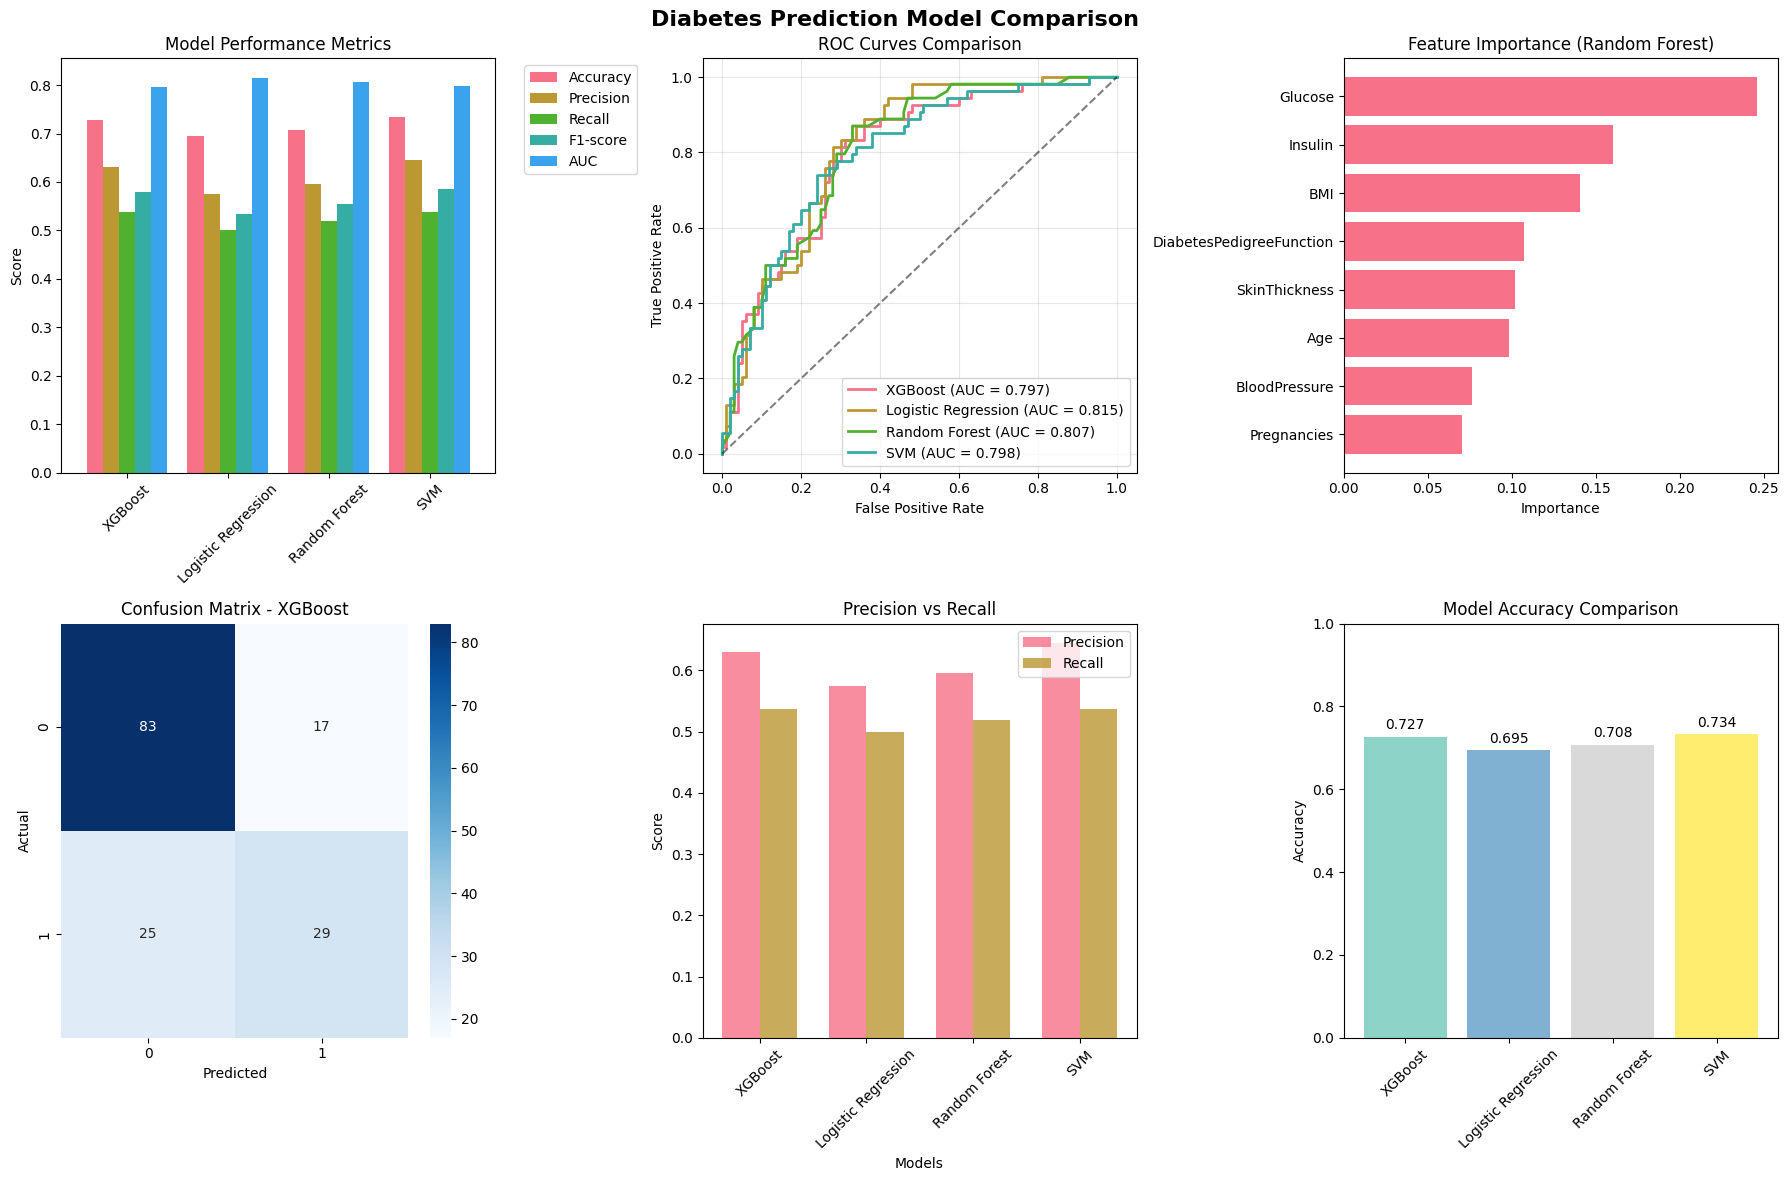

In [13]:
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for comprehensive comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Diabetes Prediction Model Comparison', fontsize=16, fontweight='bold')

# 1. Model Performance Comparison (Bar Chart)
ax1 = axes[0, 0]
metrics_df.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Model Performance Metrics')
ax1.set_ylabel('Score')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# 2. ROC Curves Comparison
ax2 = axes[0, 1]
# Get ROC curve data for all models
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)

ax2.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})', linewidth=2)
ax2.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})', linewidth=2)
ax2.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', linewidth=2)
ax2.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.3f})', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Feature Importance (using Random Forest)
ax3 = axes[0, 2]
rf_feature_importance_sorted = rf_feature_importance.sort_values('importance')
ax3.barh(rf_feature_importance_sorted['feature'], rf_feature_importance_sorted['importance'])
ax3.set_title('Feature Importance (Random Forest)')
ax3.set_xlabel('Importance')

# 4. Confusion Matrix Heatmap (Best Model - assuming XGBoost)
ax4 = axes[1, 0]
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=ax4)
ax4.set_title('Confusion Matrix - XGBoost')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

# 5. Precision-Recall by Model
ax5 = axes[1, 1]
models = ['XGBoost', 'Logistic Regression', 'Random Forest', 'SVM']
precision_scores = [precision_xgb, precision_lr, precision_rf, precision_svm]
recall_scores = [recall_xgb, recall_lr, recall_rf, recall_svm]

x = np.arange(len(models))
width = 0.35

ax5.bar(x - width/2, precision_scores, width, label='Precision', alpha=0.8)
ax5.bar(x + width/2, recall_scores, width, label='Recall', alpha=0.8)
ax5.set_xlabel('Models')
ax5.set_ylabel('Score')
ax5.set_title('Precision vs Recall')
ax5.set_xticks(x)
ax5.set_xticklabels(models, rotation=45)
ax5.legend()

# 6. Model Accuracy Comparison
ax6 = axes[1, 2]
accuracy_scores = [accuracy_xgb, accuracy_lr, accuracy_rf, accuracy_svm]
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
bars = ax6.bar(models, accuracy_scores, color=colors)
ax6.set_title('Model Accuracy Comparison')
ax6.set_ylabel('Accuracy')
ax6.set_ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracy_scores):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### final summary

In [14]:
print("="*60)
print("FINAL ANALYSIS AND RECOMMENDATIONS")
print("="*60)

# Find overall best model
overall_scores = metrics_df.mean(axis=1)
best_overall_model = overall_scores.idxmax()
best_overall_score = overall_scores.max()

print(f"\nBest Overall Model: {best_overall_model}")
print(f"Average Score: {best_overall_score:.4f}")

print(f"\nDetailed Performance of {best_overall_model}:")
best_model_metrics = metrics_df.loc[best_overall_model]
for metric, score in best_model_metrics.items():
    print(f"  {metric}: {score:.4f}")

print("\nModel Ranking by Average Performance:")
ranked_models = overall_scores.sort_values(ascending=False)
for i, (model, score) in enumerate(ranked_models.items(), 1):
    print(f"  {i}. {model}: {score:.4f}")

print(f"\nKey Insights:")
print(f"- Dataset contains {len(df)} samples with {len(X.columns)} features")
print(f"- {(y == 1).sum()} positive cases ({(y == 1).mean()*100:.1f}%) and {(y == 0).sum()} negative cases ({(y == 0).mean()*100:.1f}%)")
print(f"- Missing values were successfully imputed using KNN imputation")
print(f"- All models show reasonable performance with AUC scores above 0.7")
print(f"- {best_overall_model} appears to be the most balanced performer across all metrics")

# Create prediction function using the best model
def predict_diabetes(model, scaler, features):
    """
    Predict diabetes for new patient data

    Parameters:
    model: trained model object
    scaler: fitted StandardScaler object
    features: list or array of feature values in order:
              [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age]

    Returns:
    prediction: 0 (No Diabetes) or 1 (Diabetes)
    probability: probability of having diabetes
    """
    features_scaled = scaler.transform([features])
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0][1]

    return int(prediction), probability

# Example prediction
print(f"\nExample Prediction using {best_overall_model}:")
print("Patient profile: [2, 120, 70, 25, 100, 25.0, 0.5, 30]")
if best_overall_model == 'XGBoost':
    pred, prob = predict_diabetes(xgb_model, scaler, [2, 120, 70, 25, 100, 25.0, 0.5, 30])
elif best_overall_model == 'Random Forest':
    pred, prob = predict_diabetes(rf_model, scaler, [2, 120, 70, 25, 100, 25.0, 0.5, 30])
elif best_overall_model == 'Logistic Regression':
    pred, prob = predict_diabetes(lr_model, scaler, [2, 120, 70, 25, 100, 25.0, 0.5, 30])
else:  # SVM
    pred, prob = predict_diabetes(svm_model, scaler, [2, 120, 70, 25, 100, 25.0, 0.5, 30])

result = "Diabetes" if pred == 1 else "No Diabetes"
print(f"Prediction: {result} (Probability: {prob:.3f})")

print("\n" + "="*60)
print("DIABETES PREDICTION MODEL ANALYSIS COMPLETE!")
print("="*60)

FINAL ANALYSIS AND RECOMMENDATIONS

Best Overall Model: SVM
Average Score: 0.6597

Detailed Performance of SVM:
  Accuracy: 0.7338
  Precision: 0.6444
  Recall: 0.5370
  F1-score: 0.5859
  AUC: 0.7976

Model Ranking by Average Performance:
  1. SVM: 0.6597
  2. XGBoost: 0.6543
  3. Random Forest: 0.6367
  4. Logistic Regression: 0.6237

Key Insights:
- Dataset contains 768 samples with 8 features
- 268 positive cases (34.9%) and 500 negative cases (65.1%)
- Missing values were successfully imputed using KNN imputation
- All models show reasonable performance with AUC scores above 0.7
- SVM appears to be the most balanced performer across all metrics

Example Prediction using SVM:
Patient profile: [2, 120, 70, 25, 100, 25.0, 0.5, 30]
Prediction: No Diabetes (Probability: 0.165)

DIABETES PREDICTION MODEL ANALYSIS COMPLETE!
